In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('data/egatur_total_españa.xlsx', engine='openpyxl')

In [3]:
df.head()

,AÑO,MES,TIPO_VISITANTE,PERNOCTACIONES,GASTO_TOTAL
0,2015,10,Turista no residente (no tránsito),58846,6.134141e+09
1,2015,11,Turista no residente (no tránsito),61720,3.764707e+09
2,2015,12,Turista no residente (no tránsito),76994,3.678380e+09
3,2016,1,Turista no residente (no tránsito),60931,3.607937e+09
4,2016,2,Turista no residente (no tránsito),53764,3.622012e+09


In [4]:
df = df.drop(['TIPO_VISITANTE'], axis=1)

In [5]:
df.isnull().sum()

AÑO               0
MES               0
PERNOCTACIONES    0
GASTO_TOTAL       0
dtype: int64

In [6]:
df.dtypes

AÑO                 int64
MES                 int64
PERNOCTACIONES      int64
GASTO_TOTAL       float64
dtype: object

In [7]:
df['AÑO'] = df['AÑO'].astype(str)

# Convertir 'MES' a string y asegurarse de que tenga dos dígitos
df['MES'] = df['MES'].astype(str).str.zfill(2)

# Crear una nueva columna 'AÑO_MES' concatenando 'AÑO' y 'MES'
df['FECHA'] = df['AÑO'] + "-" + df['MES']

In [8]:
df = df.drop(['AÑO', 'MES'], axis=1)

In [13]:
print(df.head())
print(df.tail())

  PERNOCTACIONES   GASTO_TOTAL      FECHA
0          58846  6.134141e+09 2015-10-01
1          61720  3.764707e+09 2015-11-01
2          76994  3.678380e+09 2015-12-01
3          60931  3.607937e+09 2016-01-01
4          53764  3.622012e+09 2016-02-01
   PERNOCTACIONES   GASTO_TOTAL      FECHA
92          79687  1.271625e+10 2023-08-01
93          72909  1.063514e+10 2023-09-01
94          61624  9.769557e+09 2023-10-01
95          49223  6.403578e+09 2023-11-01
96          61117  6.857179e+09 2023-12-01


In [10]:
# Crear nuevas filas para abril y mayo de 2020
nuevas_filas = pd.DataFrame({
    'PERNOCTACIONES': [None, None],
    'GASTO_TOTAL': [None, None],
    'FECHA': ['2020-04', '2020-05']
})

# Añadir las nuevas filas al DataFrame original
df = pd.concat([df, nuevas_filas], ignore_index=True)

In [11]:
df['FECHA'] = pd.to_datetime(df['FECHA'], infer_datetime_format=True)

In [12]:
df.sort_values('FECHA', inplace=True)
df.isnull().sum()

PERNOCTACIONES    2
GASTO_TOTAL       2
FECHA             0
dtype: int64

In [14]:
from sklearn.impute import KNNImputer

In [15]:
# Inicializa el imputador KNN
imputer = KNNImputer(n_neighbors=3)

# Selecciona las columnas para imputar
columnas_para_imputar = ['PERNOCTACIONES', 'GASTO_TOTAL']

# Aplica la imputación KNN
df[columnas_para_imputar] = imputer.fit_transform(df[columnas_para_imputar])

In [16]:
df.dtypes

PERNOCTACIONES           float64
GASTO_TOTAL              float64
FECHA             datetime64[ns]
dtype: object

In [17]:
df.set_index('FECHA', inplace=True)

In [18]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [19]:

# Asumiendo que df es tu DataFrame y ya está ordenado por fecha
# Separar los datos en entrenamiento y prueba
cutoff = pd.to_datetime("2023-01-01")
train_df = df[df.index < cutoff]
test_df = df[df.index >= cutoff]

# Extraer solo los valores de las columnas de interés
train_data = train_df[['GASTO_TOTAL', 'PERNOCTACIONES']].values
test_data = test_df[['GASTO_TOTAL', 'PERNOCTACIONES']].values

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)



In [20]:
# Función para crear secuencias, asumiendo que 'data' ya está normalizado
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        # Definir el fin del patrón actual
        end_ix = i + n_steps
        # Recolectar los datos de entrada y salida
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Crear secuencias para entrenamiento y prueba
n_steps = 3
X_train, y_train = create_sequences(train_scaled, n_steps)
X_test, y_test = create_sequences(test_scaled, n_steps)


In [ ]:
# Encuentra el índice para el corte temporal, por ejemplo, todos los datos antes de 2023 para entrenamiento
# cut_off = pd.to_datetime("2022-01-01")
# train_idx = df.index < cut_off

# # Dividir los datos de entrada y salida en entrenamiento y prueba
# X_train, y_train = X[train_idx[:-n_steps]], y[train_idx[:-n_steps]]
# X_test, y_test = X[~train_idx[:-n_steps]], y[~train_idx[:-n_steps]]


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


# Número de pasos


In [22]:
print(np.any(np.isnan(X_train)), np.any(np.isnan(y_train)))
print(np.any(np.isinf(X_train)), np.any(np.isinf(y_train)))


False False
False False


In [23]:
# Número de características de entrada (en este caso, 'GASTO_TOTAL' y 'PERNOCTACIONES')
n_features = 2

model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, n_features)),
    Dense(n_features)  # Dos salidas ya que estamos prediciendo 'GASTO_TOTAL' y 'PERNOCTACIONES'
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [24]:
# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/50

3/3 [==============================] - 3s 229ms/step - loss: 0.2941 - val_loss: 0.4888
Epoch 2/50
3/3 [==============================] - 0s 48ms/step - loss: 0.2804 - val_loss: 0.4686
Epoch 3/50
3/3 [==============================] - 0s 49ms/step - loss: 0.2669 - val_loss: 0.4496
Epoch 4/50
3/3 [==============================] - 0s 38ms/step - loss: 0.2545 - val_loss: 0.4307
Epoch 5/50
3/3 [==============================] - 0s 36ms/step - loss: 0.2424 - val_loss: 0.4123
Epoch 6/50
3/3 [==============================] - 0s 53ms/step - loss: 0.2303 - val_loss: 0.3937
Epoch 7/50
3/3 [==============================] - 0s 33ms/step - loss: 0.2189 - val_loss: 0.3747
Epoch 8/50
3/3 [==============================] - 0s 50ms/step - loss: 0.2069 - val_loss: 0.3557
Epoch 9/50
3/3 [==============================] - 0s 37ms/step - loss: 0.1946 - val_loss: 0.3355
Epoch 10/50
3/3 [==============================] - 0s 53ms/step - loss: 0.1820 - val_loss: 0.3139
Epoch 11/50
3/3 [==========

In [25]:
# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {test_loss}')


1/1 [==============================] - 0s 47ms/step - loss: 0.0466
Test Loss: 0.04656708240509033


VAMOS A ALTERAR LOS EPOCHS Y EL BATCH SIZE

In [26]:
# Ajusta estos valores según tus necesidades
epochs = 10
batch_size = 128

# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)


Epoch 1/10
1/1 [==============================] - 0s 289ms/step - loss: 0.0317 - val_loss: 0.0259
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.0316 - val_loss: 0.0258
Epoch 3/10
1/1 [==============================] - 0s 89ms/step - loss: 0.0315 - val_loss: 0.0258
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.0314 - val_loss: 0.0257
Epoch 5/10
1/1 [==============================] - 0s 83ms/step - loss: 0.0314 - val_loss: 0.0257
Epoch 6/10
1/1 [==============================] - 0s 80ms/step - loss: 0.0313 - val_loss: 0.0256
Epoch 7/10
1/1 [==============================] - 0s 97ms/step - loss: 0.0312 - val_loss: 0.0256
Epoch 8/10
1/1 [==============================] - 0s 105ms/step - loss: 0.0311 - val_loss: 0.0255
Epoch 9/10
1/1 [==============================] - 0s 95ms/step - loss: 0.0310 - val_loss: 0.0255
Epoch 10/10
1/1 [==============================] - 0s 92ms/step - loss: 0.0309 - val_loss: 0.0254


In [27]:
# Evaluar el modelo
loss = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {loss}')


1/1 [==============================] - 0s 48ms/step - loss: 0.0461
Test Loss: 0.04614336043596268


In [29]:
# Asumiendo que tienes 'train_scaled' que es tu conjunto de datos normalizados

# Obtener la última secuencia de datos
last_sequence = train_scaled[-n_steps:]

# Preparar la secuencia para predicción (añadir dimensión extra)
last_sequence = np.expand_dims(last_sequence, axis=0)

# Contenedor para las predicciones
predictions = []

# Generar predicciones para los próximos 12 meses
for _ in range(12):
    # Hacer la predicción usando la última secuencia
    pred = model.predict(last_sequence)
    
    # Añadir la predicción al final de la secuencia
    predictions.append(pred[0])
    
    # Actualizar la secuencia para incluir la nueva predicción
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, :] = pred

# Desnormalizar las predicciones si es necesario
predictions = scaler.inverse_transform(predictions)



1/1 [==============================] - 0s 37ms/step


In [30]:

# La última fecha en tu DataFrame
last_date = df.index[-1]

# Generar fechas futuras para las predicciones
future_dates = pd.date_range(start=last_date, periods=len(predictions) + 1, freq='M')[1:]



In [31]:
predictions_gasto_total = predictions[:, 0]
predictions_pernoctaciones = predictions[:, 1]


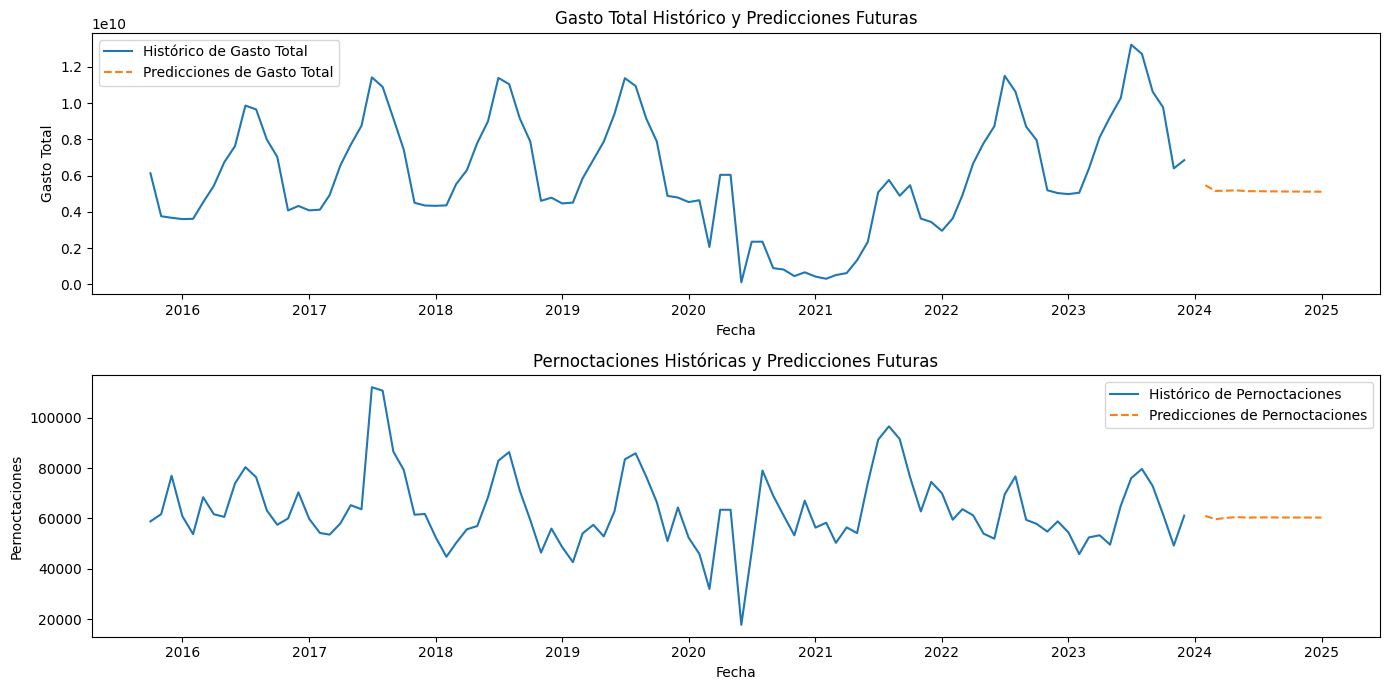

In [32]:
# Configurar el tamaño de la figura
plt.figure(figsize=(14, 7))

# Gráfico para GASTO_TOTAL
plt.subplot(2, 1, 1)  # 2 filas, 1 columna, posición 1
plt.plot(df.index, df['GASTO_TOTAL'], label='Histórico de Gasto Total')
plt.plot(future_dates, predictions_gasto_total, label='Predicciones de Gasto Total', linestyle='--')
plt.title('Gasto Total Histórico y Predicciones Futuras')
plt.xlabel('Fecha')
plt.ylabel('Gasto Total')
plt.legend()

# Gráfico para PERNOCTACIONES
plt.subplot(2, 1, 2)  # 2 filas, 1 columna, posición 2
plt.plot(df.index, df['PERNOCTACIONES'], label='Histórico de Pernoctaciones')
plt.plot(future_dates, predictions_pernoctaciones, label='Predicciones de Pernoctaciones', linestyle='--')
plt.title('Pernoctaciones Históricas y Predicciones Futuras')
plt.xlabel('Fecha')
plt.ylabel('Pernoctaciones')
plt.legend()

# Ajustar layout y mostrar el gráfico
plt.tight_layout()
plt.show()